In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
train_data=pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
test_data=pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


In [5]:
RESULT_DICT={0:'entailment',1:'neutral',2:'contradiction'}

Text(0.5, 1.0, 'Distribution of labels in the training set')

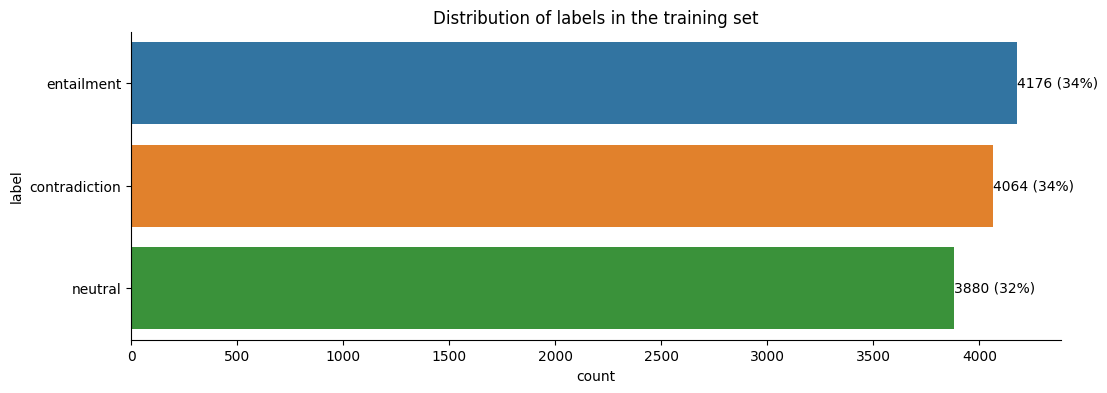

In [6]:
f, ax = plt.subplots(figsize=(12, 4))

sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=train_data, 
                   y="label",
                   order = train_data['label'].value_counts().index)

abs_values = train_data['label'].value_counts(ascending=False)
rel_values = train_data['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

Text(0.5, 1.0, 'Distribution of languages in the training set')

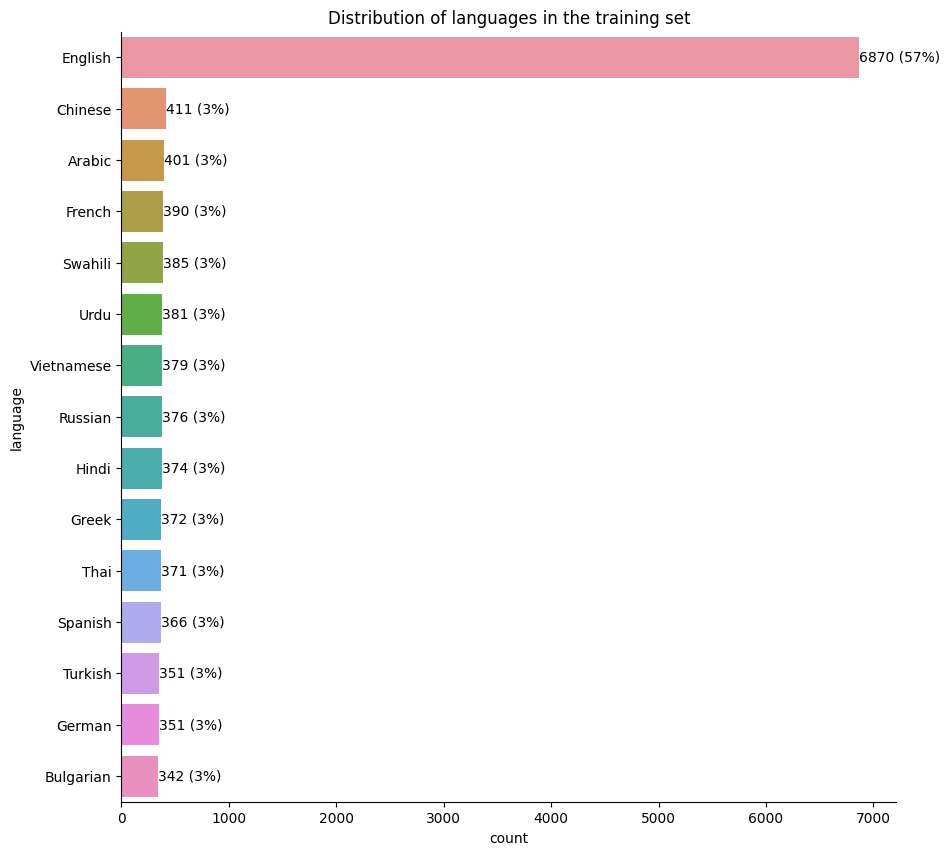

In [7]:
f, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=train_data, 
                   y="language",
                   order = train_data['language'].value_counts().index)

abs_values = train_data['language'].value_counts(ascending=False)
rel_values = train_data['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")


**Preprocessing**

In [8]:
import transformers
from transformers import BertModel,BertTokenizer,get_linear_schedule_with_warmup,AdamW

In [9]:
Pre_Model='bert-base-multilingual-uncased'
tokenizer=BertTokenizer.from_pretrained(Pre_Model)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/tmp/ipykernel_850/213680152.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN

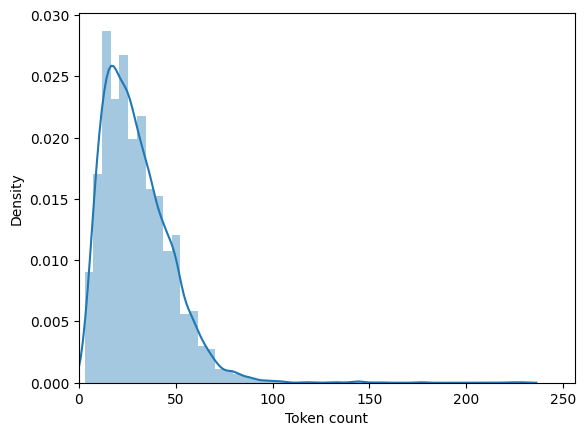

In [10]:
token_lens=[]
for txt in train_data.premise:
    tokens=tokenizer.encode(txt,max_length=512)
    token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

/tmp/ipykernel_850/2456456879.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens_hp)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


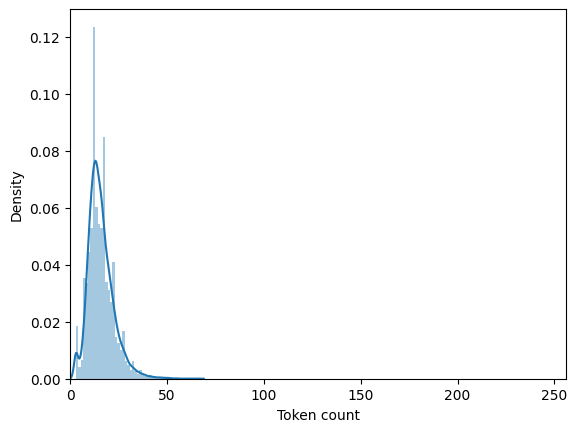

In [11]:
token_lens_hp=[]
for txt in train_data.hypothesis:
    tokens=tokenizer.encode(txt,max_length=512)
    token_lens_hp.append(len(tokens))
sns.distplot(token_lens_hp)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [12]:
train_data.hypothesis

0        The rules developed in the interim were put to...
1        Practice groups are not permitted to work on t...
2                    J'essayais d'accomplir quelque chose.
3        They can't defend themselves because of their ...
4          เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร
                               ...                        
12115    All studies have the same amount of uncertaint...
12116    But there are two kinds of the pleasure of doi...
12117                     It cannot be moved, now or ever.
12118         The model temple complex is at the east end.
12119        Ataturk was the father of the Turkish nation.
Name: hypothesis, Length: 12120, dtype: object

In [13]:
max_len=150

In [14]:
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F

In [15]:
import torch
from torch.utils.data import Dataset

class preprocess(Dataset):
    def __init__(self, premise, hypothesis, labels, tokenizer, max_len):
        self.premise = premise
        self.hypothesis = hypothesis
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        premise = str(self.premise[item])
        hypothesis = str(self.hypothesis[item])
        label = self.labels[item]
        
        
        premise_encoding = self.tokenizer.encode(premise, add_special_tokens=False)
        hypothesis_encoding = self.tokenizer.encode(hypothesis, add_special_tokens=False)
        
        
        special_tokens_count = 3  # [CLS], [SEP], [SEP]
        max_seq_len = self.max_len - special_tokens_count
        
        
        if len(premise_encoding) + len(hypothesis_encoding) > max_seq_len:
            premise_ratio = len(premise_encoding) / (len(premise_encoding) + len(hypothesis_encoding))
            premise_max_len = int(max_seq_len * premise_ratio)
            hypothesis_max_len = max_seq_len - premise_max_len
            
            premise_encoding = premise_encoding[:premise_max_len]
            hypothesis_encoding = hypothesis_encoding[:hypothesis_max_len]

        
        combined_encoding = ([self.tokenizer.cls_token_id] + 
                             premise_encoding + 
                             [self.tokenizer.sep_token_id] + 
                             hypothesis_encoding + 
                             [self.tokenizer.sep_token_id])
        
        
        padding_length = self.max_len - len(combined_encoding)
        attention_mask = [1] * len(combined_encoding) + [0] * padding_length
        combined_encoding += [self.tokenizer.pad_token_id] * padding_length

        return {
            'premise': premise,
            'hypothesis': hypothesis,
            'input_ids': torch.tensor(combined_encoding, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [16]:
#from sklearn.model_selection import train_test_split
#train_set,val_set,test_set=train_test_split(train_data,test_size=0.3,shuffle=True)

In [17]:
train_set,val_set,test_set=np.split(train_data.sample(frac=1, random_state=42), [int(.6*len(train_data)), int(.8*len(train_data))])


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [18]:
train_data.label

0        0
1        2
2        0
3        0
4        1
        ..
12115    2
12116    0
12117    2
12118    2
12119    0
Name: label, Length: 12120, dtype: int64

In [19]:
import torch

In [20]:
def create_data_loader(data,tokenizer,max_len,batch_size):
    pr=preprocess(
        premise=data.premise.to_numpy(),
        hypothesis=data.hypothesis.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
        labels=data.label.to_numpy()
        )
    return DataLoader(
        pr,
        batch_size=batch_size,
        num_workers=2
    )

In [21]:
batch_size=16
train_dataloader=create_data_loader(train_set,tokenizer,max_len,batch_size)
val_dataloader=create_data_loader(val_set,tokenizer,max_len,batch_size)
test_dataloader=create_data_loader(test_set,tokenizer,max_len,batch_size)

In [22]:
data=next(iter(train_dataloader))
data.keys()

dict_keys(['premise', 'hypothesis', 'input_ids', 'attention_mask', 'label'])

In [23]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [24]:
bert_model=BertModel.from_pretrained('bert-base-multilingual-uncased')

In [25]:
data['input_ids']

tensor([[  101, 29121,   136,  ...,     0,     0,     0],
        [  101, 14399, 10320,  ...,     0,     0,     0],
        [  101, 30517, 10114,  ...,     0,     0,     0],
        ...,
        [  101, 10104, 15000,  ...,     0,     0,     0],
        [  101, 23810, 10992,  ...,     0,     0,     0],
        [  101, 11312, 18480,  ...,     0,     0,     0]])

In [26]:
last_hidden_state,pooled_output=bert_model(
    input_ids=data['input_ids'],
    attention_mask=data['attention_mask'],
    return_dict=False
)

In [27]:
last_hidden_state.shape

torch.Size([16, 150, 768])

In [31]:
class SentenceClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentenceClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(Pre_Model, return_dict=False)
        for param in self.bert.parameters():
            param.requires_grad = True
    
        self.dropout = nn.Dropout(0.4)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.dropout(pooled_output)
        return self.out(output)

In [32]:
SentenceClassifier(len(RESULT_DICT))

SentenceClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [33]:
model=SentenceClassifier(len(RESULT_DICT))
model=model.to(device)

In [34]:
input_ids=data['input_ids'].to(device)
attention_mask=data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 150])
torch.Size([16, 150])


In [35]:
F.softmax(model(input_ids,attention_mask),dim=1)

tensor([[0.3880, 0.2267, 0.3852],
        [0.4248, 0.2485, 0.3267],
        [0.3842, 0.3231, 0.2927],
        [0.3849, 0.2593, 0.3558],
        [0.3615, 0.2256, 0.4128],
        [0.3684, 0.2308, 0.4009],
        [0.3980, 0.2488, 0.3532],
        [0.4109, 0.2260, 0.3631],
        [0.3671, 0.2746, 0.3584],
        [0.3857, 0.3143, 0.3001],
        [0.4115, 0.2564, 0.3320],
        [0.3774, 0.2545, 0.3681],
        [0.3867, 0.2129, 0.4004],
        [0.3955, 0.2492, 0.3553],
        [0.4004, 0.3187, 0.2809],
        [0.3786, 0.2893, 0.3322]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [36]:
from torch.optim import AdamW
EPOCHS=4
optimizer = AdamW([
    {'params': model.bert.parameters(), 'lr': 2e-5, 'weight_decay':0.1},
    {'params': model.out.parameters(), 'lr': 1e-3, 'weight_decay':0.1}
])
total_steps=len(train_dataloader)*EPOCHS

scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn=nn.CrossEntropyLoss().to(device)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)



tensor(0.)

In [37]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    label = d["label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, label)

    correct_predictions += torch.sum(preds == label)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, label)

      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [39]:
from collections import defaultdict


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_dataloader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train_set)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_dataloader,
    loss_fn, 
    device, 
    len(val_set)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 1.0717983788186378 accuracy 0.40456545654565457
Val   loss 0.8976439174852873 accuracy 0.5862211221122112

Epoch 2/4
----------
Train loss 0.8478104102742541 accuracy 0.6188118811881188
Val   loss 0.8604134797657791 accuracy 0.6481023102310232

Epoch 3/4
----------
Train loss 0.6103622510374247 accuracy 0.7486248624862486
Val   loss 0.9404213749068348 accuracy 0.6468646864686469

Epoch 4/4
----------
Train loss 0.44004085516700375 accuracy 0.8278327832783278
Val   loss 1.030304605239316 accuracy 0.6489273927392739



In [40]:
test_acc, _ = eval_model(model,test_dataloader,loss_fn,device,len(test_set))
test_acc.item()-

0.6283003300330033